Fear-Greed Columns: ['timestamp', 'value', 'classification', 'date']
Trader Columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Merged rows: 211218


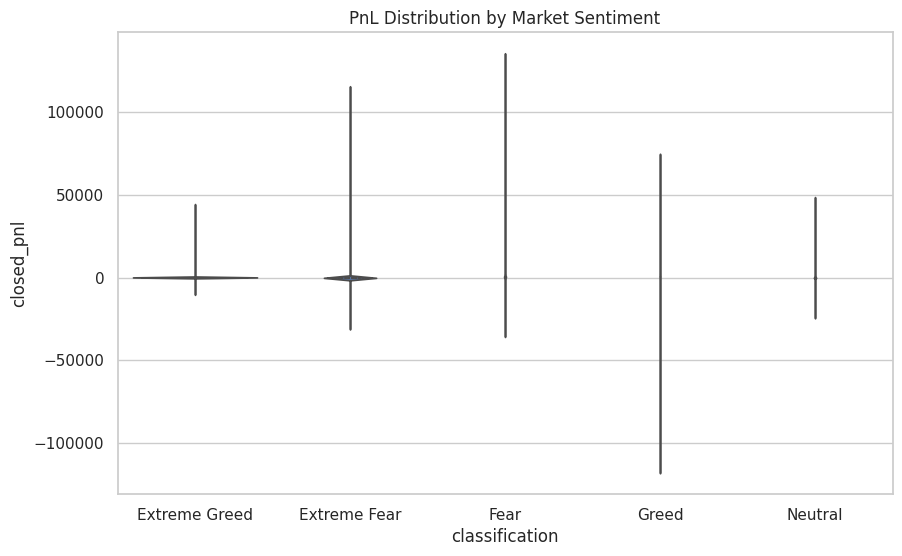

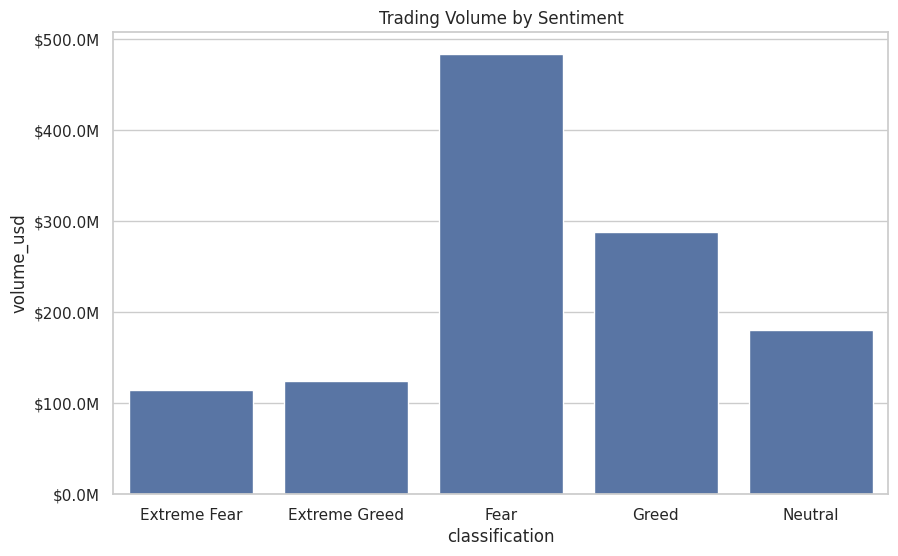

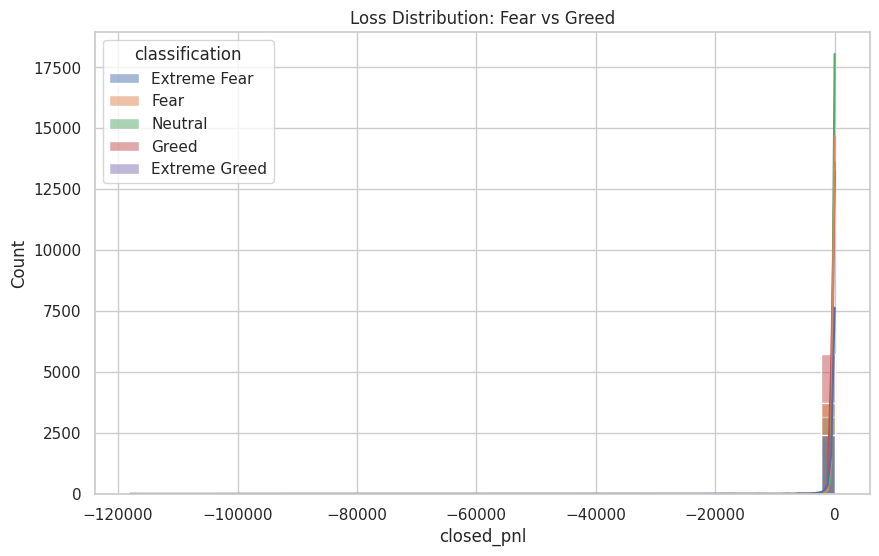

/tmp/ipython-input-2493057201.py:127: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = pd.pivot_table(


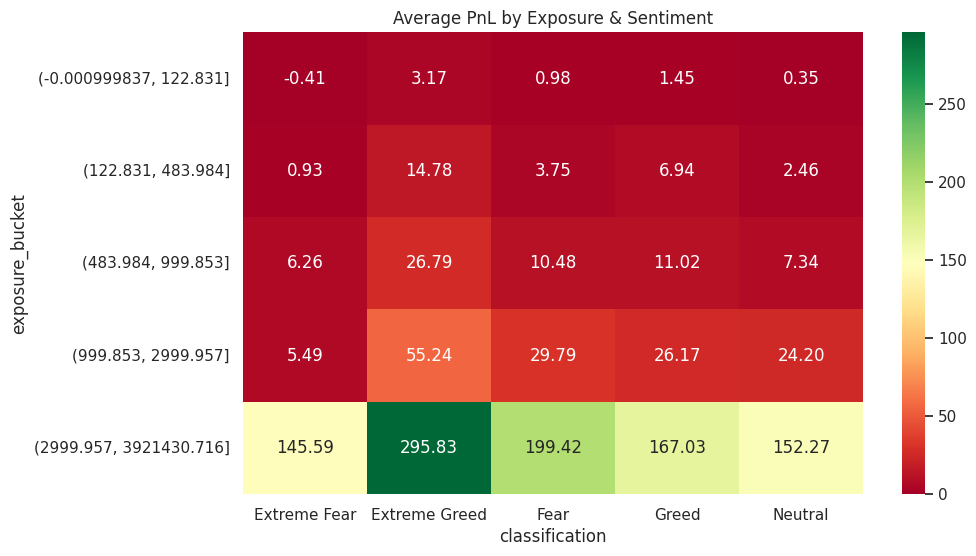

T-statistic: 1.851
P-value: 0.064152

SUMMARY METRICS
               closed_pnl                        volume_usd
                     mean median          std           sum
classification                                             
Extreme Fear    34.537862    0.0  1136.056091  1.144843e+08
Extreme Greed   67.892861    0.0   766.828294  1.244652e+08
Fear            54.290400    0.0   935.355438  4.833248e+08
Greed           42.743559    0.0  1116.028390  2.885825e+08
Neutral         34.307718    0.0   517.122220  1.802421e+08


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from matplotlib.ticker import FuncFormatter
import os

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

os.makedirs("csv_files", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


fear_greed = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

fear_greed.columns = fear_greed.columns.str.strip().str.lower()
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")

print("Fear-Greed Columns:", fear_greed.columns.tolist())
print("Trader Columns:", trades.columns.tolist())



if 'date' in fear_greed.columns:
    fear_greed['date'] = pd.to_datetime(
        fear_greed['date'],
        errors='coerce'
    ).dt.date
elif 'timestamp' in fear_greed.columns:
    fear_greed['date'] = pd.to_datetime(
        fear_greed['timestamp'],
        errors='coerce'
    ).dt.date
else:
    raise KeyError("No valid date column in fear_greed dataset")

if 'timestamp_ist' in trades.columns:
    trades['date'] = pd.to_datetime(
        trades['timestamp_ist'],
        dayfirst=True,
        errors='coerce'
    ).dt.date
elif 'timestamp' in trades.columns:
    trades['date'] = pd.to_datetime(
        trades['timestamp'],
        errors='coerce'
    ).dt.date
else:
    raise KeyError("No valid timestamp column in trader dataset")


trades = trades.dropna(subset=['date'])
fear_greed = fear_greed.dropna(subset=['date'])

required = ['size_tokens', 'size_usd', 'execution_price', 'closed_pnl']
trades = trades.dropna(subset=required)
trades = trades[trades['size_tokens'] > 0]

df = pd.merge(
    trades,
    fear_greed[['date', 'classification']],
    on='date',
    how='inner'
)

print("Merged rows:", len(df))


df['volume_usd'] = df['size_usd']
df['exposure'] = df['execution_price'] * df['size_tokens']
df['exposure_bucket'] = pd.qcut(df['exposure'], q=5)
df['pnl_bucket'] = pd.qcut(
    df['closed_pnl'],
    q=5,
    labels=False,
    duplicates='drop'
)


df.to_csv("csv_files/processed_trader_sentiment_data.csv", index=False)


sns.violinplot(x='classification', y='closed_pnl', data=df, inner='quartile')
plt.title("PnL Distribution by Market Sentiment")
plt.savefig("outputs/pnl_violin.png")
plt.show()

volume_summary = df.groupby('classification')['volume_usd'].sum().reset_index()
sns.barplot(x='classification', y='volume_usd', data=volume_summary)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
plt.title("Trading Volume by Sentiment")
plt.savefig("outputs/volume_sentiment.png")
plt.show()

loss_df = df[df['closed_pnl'] < 0]
sns.histplot(loss_df, x='closed_pnl', hue='classification', bins=50, kde=True)
plt.title("Loss Distribution: Fear vs Greed")
plt.savefig("outputs/loss_distribution.png")
plt.show()

pivot = pd.pivot_table(
    df,
    values='closed_pnl',
    index='exposure_bucket',
    columns='classification',
    aggfunc='mean'
)

sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlGn")
plt.title("Average PnL by Exposure & Sentiment")
plt.savefig("outputs/pnl_exposure_heatmap.png")
plt.show()


fear_pnl = df[df['classification'] == 'Fear']['closed_pnl']
greed_pnl = df[df['classification'] == 'Greed']['closed_pnl']

t_stat, p_value = ttest_ind(fear_pnl, greed_pnl, equal_var=False)

print("T-statistic:", round(t_stat, 3))
print("P-value:", round(p_value, 6))


summary = df.groupby('classification').agg({
    'closed_pnl': ['mean', 'median', 'std'],
    'volume_usd': 'sum'
})

print("\nSUMMARY METRICS")
print(summary)

